In [1]:
library(auk)
library(lubridate)
library(sf)
library(gridExtra)
library(tidyverse)
# resolve namespace conflicts
select <- dplyr::select

auk 0.4.2 is designed for EBD files downloaded after 2019-08-15. 
EBD data directory:  /mnt/Windows/Users/Nimo/Documents/eBird 
eBird taxonomy version:  2019


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ dplyr::combine()         masks gridExtra::combine()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate

In [2]:
ebd <- read_ebd("../data/ebird/output/ebd_barswa_1950_2020.txt")

In [3]:
ebd_filtered <- ebd %>%
    # select columns we need
    select(observation_count, latitude, longitude, observation_date) %>%
    # filter out observations outside europe/africa
    filter(-10 < longitude & longitude < 60) %>%
    # clean up variables
    mutate(
        # convert X to NA
        observation_count = if_else(observation_count == "X", NA_character_, observation_count),
        # convert counts to integers
        observation_count = as.integer(observation_count)
    )

glimpse(ebd_filtered)

Rows: 469,385
Columns: 4
$ observation_count <int> NA, 5, 10, 1, NA, 2, NA, NA, NA, NA, 2, 30, NA, NA,…
$ latitude          <dbl> 37.27469, 63.27550, 41.19103, 24.81083, 65.95672, 4…
$ longitude         <dbl> -6.5242499, 25.8797657, 1.4183605, 46.8662200, 29.1…
$ observation_date  <date> 1973-07-10, 1973-05-19, 1994-07-13, 1992-05-12, 19…


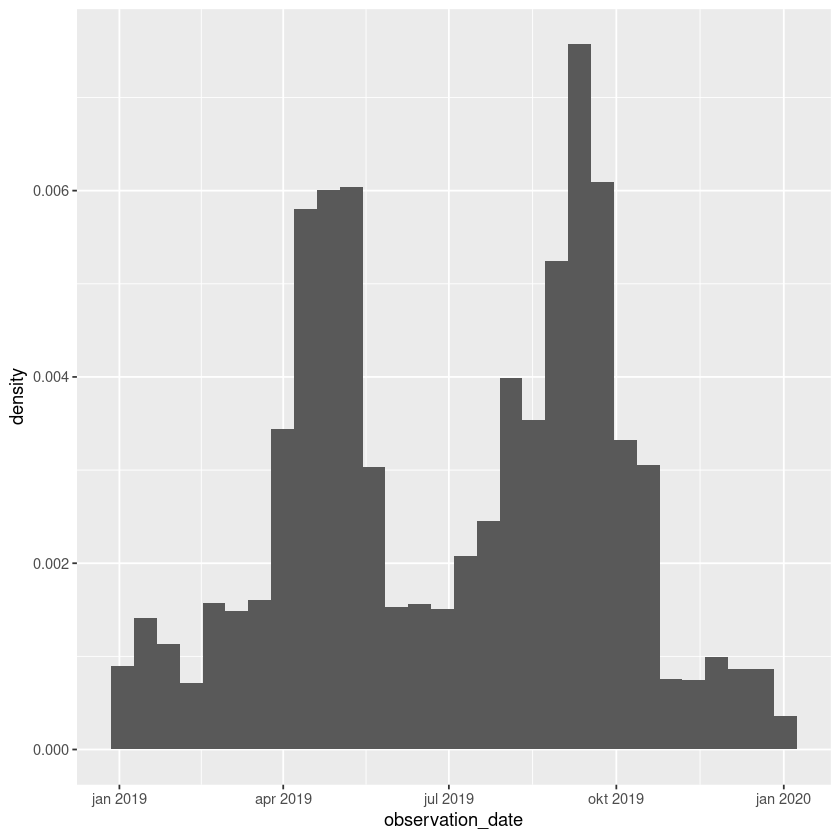

In [5]:
ebd_counts <- ebd_filtered %>%
    filter(!is.na(observation_count)) %>%
    group_by(observation_date) %>%
    summarize(sum_count = sum(observation_count), .groups="drop")

ggplot(ebd_counts) + geom_histogram(aes(x=observation_date, y=..density.., weight=sum_count), bins=30)

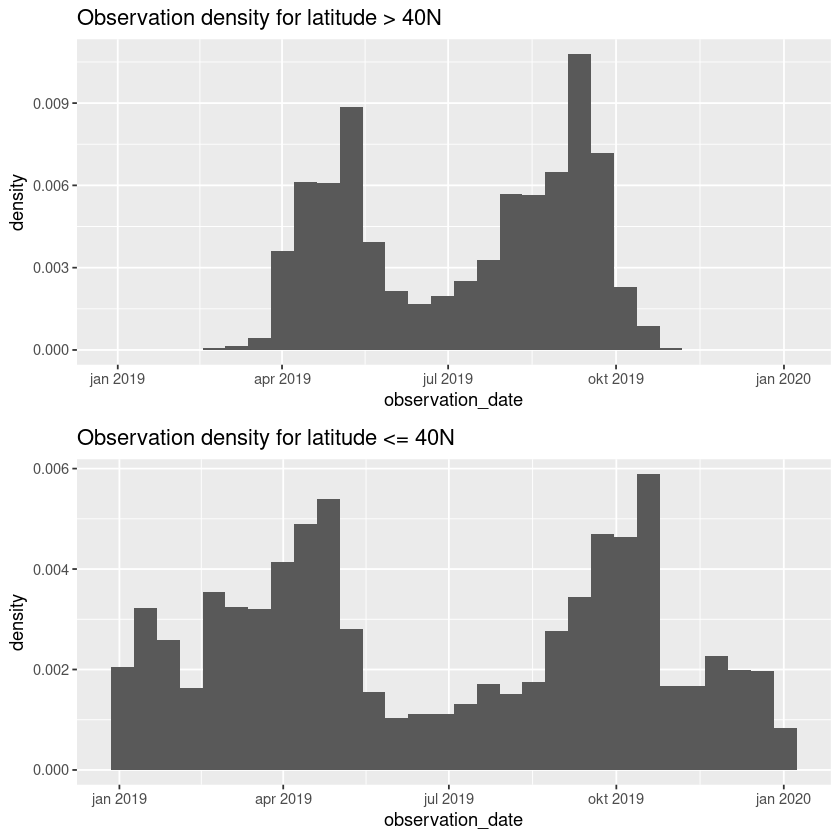

In [6]:
ebd_north <- ebd_filtered %>%
    filter(latitude > 40 & !is.na(observation_count)) %>%
    group_by(observation_date) %>%
    summarize(sum_count = sum(observation_count), .groups="drop")

plot_north <- ggplot(ebd_north) + geom_histogram(aes(x=observation_date, y=..density.., weight=sum_count), bins=30) + labs(title="Observation density for latitude > 40N")

ebd_south <- ebd_filtered %>%
    filter(latitude <= 40 & !is.na(observation_count)) %>%
    group_by(observation_date) %>%
    summarize(sum_count = sum(observation_count), .groups="drop")

plot_south <- ggplot(ebd_south) + geom_histogram(aes(x=observation_date, y=..density.., weight=sum_count), bins=30) + labs(title="Observation density for latitude <= 40N")

grid.arrange(plot_north, plot_south)

In [4]:
ebd_export <- ebd_filtered %>%
    transmute(
        date = as.integer(observation_date), # number of days since 1970-01-01
        lat = latitude,
        lon = longitude,
        count = observation_count
    ) %>%
    filter(!is.na(count)) %>%
    arrange(date)

output_dir <- "../data/ebird/output"

write.table(ebd_export, file.path(output_dir, "ebd_export.csv"), sep=",", row.names = FALSE, col.names = FALSE)

# library('rjson')
# write(toJSON(ebd_export), file.path(output_dir, "ebd_export.json"))